<h1><center><font color=purple>Plotting a choropleth map of Zurich's city districts</font></center></h1>
<h4><center><font color=purple>1) using Pandas, Matplotlib and Folium</font></center></h4>

***

<strong>Key objectives:<br></strong>Create a region map (choropleth map) of Zurich's city districts using <b> Pandas, Matplotlib and Folium</b>. Information for districts should be shown by coloring each disctrict according to a corresponding value. The color palette should be shown in a legend. Ideally the map should be interactive.

<strong>Dataset:<br></strong> (1) <i>'Generalisierte Gemeindegrenzen (OGD) (kantonaler Datensatz)'</i> from https://www.stadt-zuerich.ch/geodaten/

<h3><left><font color=purple>Contents:</font></left></h3>

[1. Import shapefiles](#section-1-title)

[2. Plot a single city district of Zürich](#section-2-title)

[3. Plot all districts of Zürich](#section-3-title)

[4. Highlight a subset of Zürich's districts](#section-4-title)

[5. Color districts according to some data](#section-5-title)

[6. Display districts in interactive map](#section-6-title)

[7. Discussion](#section-7-title)
***

In [29]:
# imports
import numpy as np
import pandas as pd
import shapefile as shp
from pyproj import Transformer
import folium
import matplotlib.pyplot as plt
%matplotlib inline

<a id='section-1-title'></a>
[<h3><font color=purple>1. Import shapefiles</font></h3>](#section-1-title)

In [30]:
# load shapefile
shp_path = 'data/raw/stadtkreise/UP_GEMEINDEN_STADTQUARTIERE_F.shp'
sf1 = shp.Reader(shp_path, encoding = "ISO8859-1")
# diplay length of shapefile
print('Number of entries of shapefile:',len(sf1.shapes()))

Number of entries of shapefile: 239


In [31]:
# display first five entries
sf1.records()[:5]

[Record #0: [12, 'Rifferswil', 'Affoltern', '', None, 'Gemeinde', 1, 6509791.98405747, 15891.2533675368],
 Record #1: [261, 'Zürich', 'Zürich', 'Friesenberg', 33, 'Gemeinde', 1, 5297365.56092282, 13298.9572162507],
 Record #2: [248, 'Uitikon', 'Dietikon', '', None, 'Gemeinde', 1, 4378204.98610885, 14116.0447778514],
 Record #3: [261, 'Zürich', 'Zürich', 'Albisrieden', 91, 'Gemeinde', 1, 4601382.99302979, 10000.2914910663],
 Record #4: [261, 'Zürich', 'Zürich', 'Alt-Wiedikon', 31, 'Gemeinde', 1, 1692462.30810657, 9256.15698610195]]

In [32]:
# define function for reading the shapefile into a Pandas dataframe
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information.
    """
    fields = [x[0] for x in sf.fields][1:]
    records = [x[0:] for x in sf1.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return(df)

In [33]:
# reading the shapefile into a Pandas dataframe and display first few columns 
df = read_shapefile(sf1)
df.head()

,BFS,GEMEINDENA,BEZIRKSNAM,QUARTIERNA,QUARTIERNU,ART_TEXT,ART_CODE,SHAPE_AREA,SHAPE_LEN,coords
0,12,Rifferswil,Affoltern,,NaN,Gemeinde,1,6.509792e+06,15891.253368,"[(2680429.631000001, 1235062.5340999998), (268..."
1,261,Zürich,Zürich,Friesenberg,33.0,Gemeinde,1,5.297366e+06,13298.957216,"[(2680607.002799999, 1247034.3073999994), (268..."
2,248,Uitikon,Dietikon,,NaN,Gemeinde,1,4.378205e+06,14116.044778,"[(2676260.659000002, 1248138.1950999983), (267..."
3,261,Zürich,Zürich,Albisrieden,91.0,Gemeinde,1,4.601383e+06,10000.291491,"[(2679845.504999999, 1248527.4349999987), (267..."
4,261,Zürich,Zürich,Alt-Wiedikon,31.0,Gemeinde,1,1.692462e+06,9256.156986,"[(2681239.0579999983, 1247192.2219999991), (26..."


<a id="section-2-title"></a>
[<h3><font color=purple>2. Plot a single city district of Zürich</font></h3>](#section-2-title)

In [34]:
# keep only districts that belong to Zürich (GEMEINDENA == 'Zürich') in the dataframe and display first few columns
df = df.loc[df.GEMEINDENA=='Zürich'].reset_index(drop=True)
df.head()

,BFS,GEMEINDENA,BEZIRKSNAM,QUARTIERNA,QUARTIERNU,ART_TEXT,ART_CODE,SHAPE_AREA,SHAPE_LEN,coords
0,261,Zürich,Zürich,Friesenberg,33.0,Gemeinde,1,5.297366e+06,13298.957216,"[(2680607.002799999, 1247034.3073999994), (268..."
1,261,Zürich,Zürich,Albisrieden,91.0,Gemeinde,1,4.601383e+06,10000.291491,"[(2679845.504999999, 1248527.4349999987), (267..."
2,261,Zürich,Zürich,Alt-Wiedikon,31.0,Gemeinde,1,1.692462e+06,9256.156986,"[(2681239.0579999983, 1247192.2219999991), (26..."
3,261,Zürich,Zürich,Escher Wyss,52.0,Gemeinde,1,1.266278e+06,7435.112993,"[(2680539.925999999, 1249894.0909999982), (268..."
4,261,Zürich,Zürich,Unterstrass,61.0,Gemeinde,1,2.466186e+06,10012.328898,"[(2682229.147999998, 1251558.5749999993), (268..."


In [35]:
# define function for plotting a single shape / district 

def plot_shape(id,df,ax,mode='outlines',outlinecolor='k',shownames=True,fillcolor=None):
    """Arguments
    id: id of the record to be plotted
    df: dataframe
    ax: axes object
    mode: either 'outlines' or 'fill'
    outlinecolor: color of the shape outlines
    shownames: boolean which defines if names of the district are plotted alongside its shape
    fillcolor: color of the shape
"""
    if mode not in ['outlines','fill']: 
        raise ValueError("mode must be either 'outlines' or 'fill'")
    if not isinstance(shownames, bool):
        raise ValueError("shownames must be a boolean")
    
    ax.set_aspect('equal')
    coords = df.loc[id,'coords']
    x_lon = np.zeros((len(coords),1))
    y_lat = np.zeros((len(coords),1))
    for ip in range(len(coords)):
        x_lon[ip] = coords[ip][0]
        y_lat[ip] = coords[ip][1]
    ax.plot(x_lon,y_lat,color=outlinecolor)
    if mode != 'outlines':
        if fillcolor is None:
            ax.fill(x_lon,y_lat)
        else:
            ax.fill(x_lon,y_lat,color=fillcolor)
    if shownames:
        s = df.loc[id,'QUARTIERNA']
        x0 = np.mean([max(x_lon),min(x_lon)])
        y0 = np.mean([max(y_lat),min(y_lat)])
        ax.text(x0, y0, s, fontsize=10,ha='center')
    ax.set_facecolor('#fcfcfc')
    ax.grid(False)

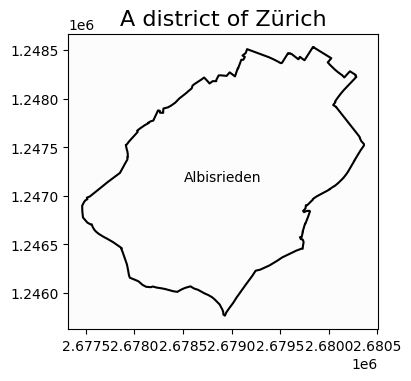

In [36]:
# plot a single district
id = 1

fig, ax = plt.subplots(figsize=(4,4))
plot_shape(id,df,ax,outlinecolor='k',shownames=True)
ax.set_title('A district of Zürich',size=16);

<a id="section-3-title"></a>
[<h3><font color=purple>3. Plot all districts of Zürich</font></h3>](#section-3-title)

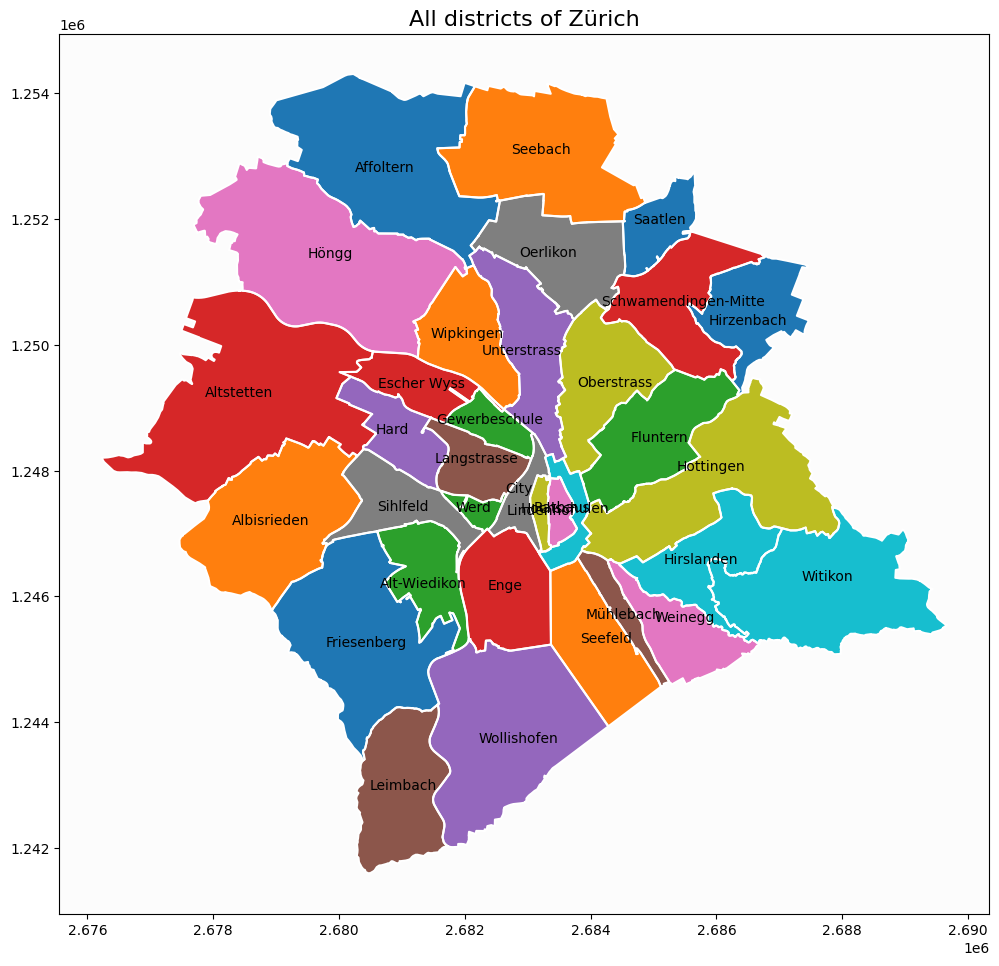

In [37]:
# plot all districts
fig, ax = plt.subplots(figsize=(12,12))

for district in df.itertuples():
    plot_shape(district.Index,df,ax,mode='fill',outlinecolor='white')
ax.set_title('All districts of Zürich',size=16);

<a id="section-4-title"></a>
[<h3><font color=purple>4. Highlight a subset of Zürich's districts</font></h3>](#section-4-title)

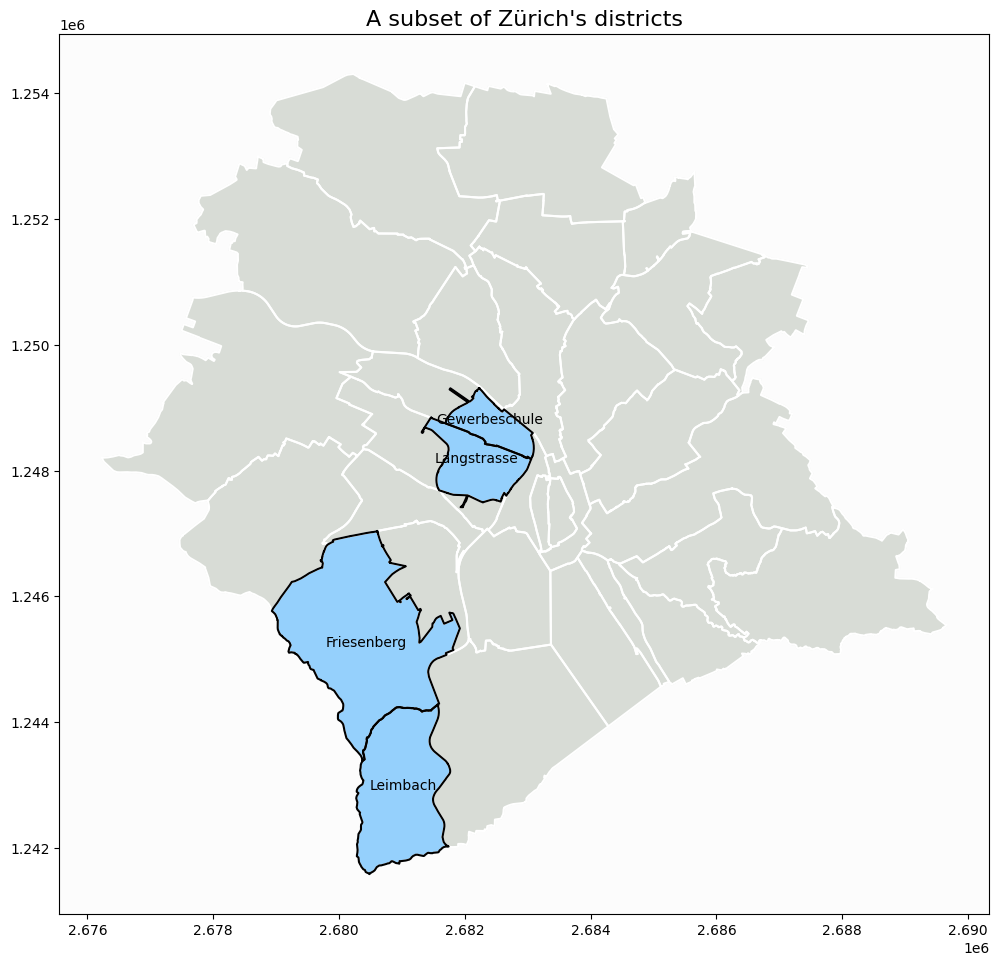

In [38]:
# plot a subset of the districts
district_list = ['Langstrasse','Gewerbeschule','Leimbach','Friesenberg']

fig, ax = plt.subplots(figsize=(12,12))

for district in df.itertuples():
    plot_shape(district.Index,df,ax,mode='fill',outlinecolor='w',shownames=False,fillcolor='xkcd:light grey')

for district in df[df.QUARTIERNA.isin(district_list)].itertuples():
    plot_shape(district.Index,df,ax,mode='fill',outlinecolor='k',shownames=True,fillcolor='xkcd:light blue')

ax.set_title("A subset of Zürich's districts",size=16);

<a id="section-5-title"></a>
[<h3><font color=purple>5. Color districts according to some data</font></h3>](#section-5-title)

In [39]:
# create color palette 1
from colour import Color
color1_str = 'green'
color2_str = 'red'
n_bins = 30
data = df.SHAPE_AREA.tolist()
data_bin_numbers, bins = pd.qcut(data, n_bins, retbins=True, labels=list(range(n_bins)))
starting_color = Color(color1_str)
color_sq = [c.hex for c in starting_color.range_to(Color(color2_str),n_bins)]

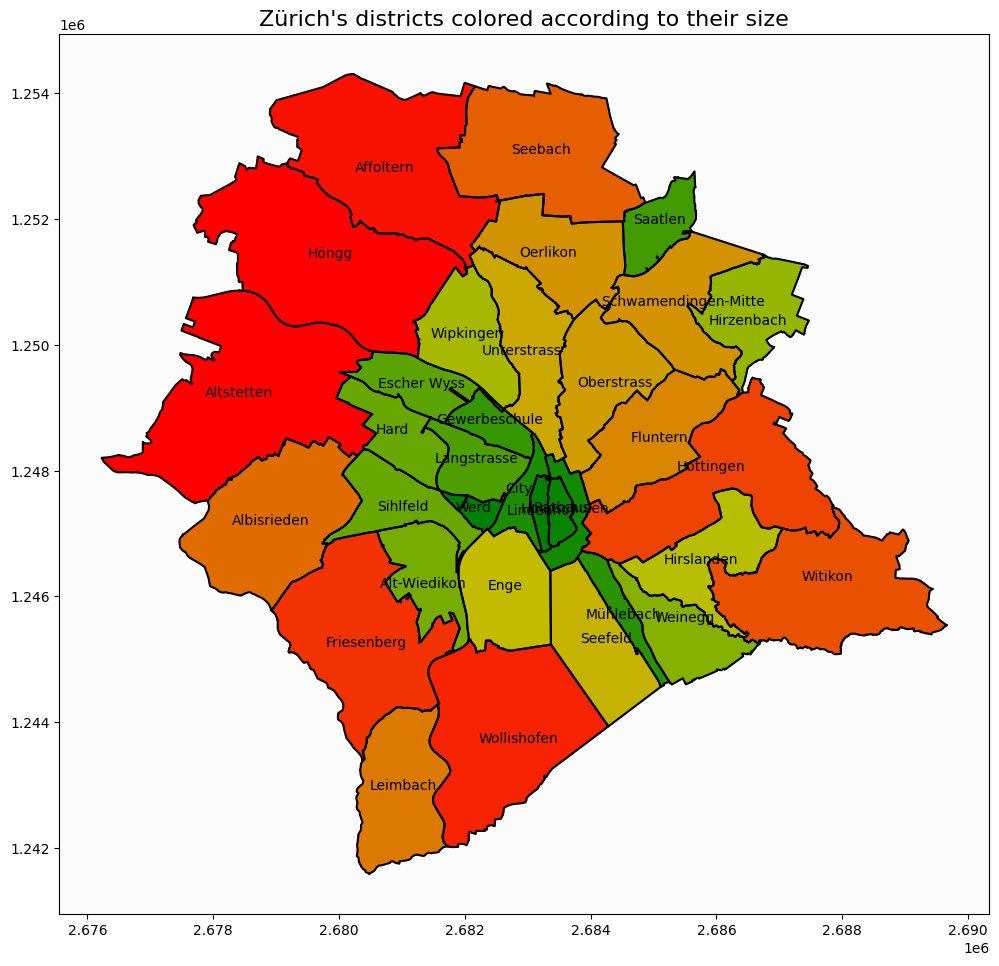

In [40]:
# plot using palette 1
data_color_tone = []
for val in data_bin_numbers:
    data_color_tone.append(color_sq[val]) 

fig, ax = plt.subplots(figsize=(12,12))
for i,district in df.iterrows():
    plot_shape(i,df,ax,mode='fill',outlinecolor='k',shownames=True,fillcolor=data_color_tone[i])

ax.set_title("Zürich's districts colored according to their size",size=16);

In [41]:
# create color palette 2
color1_str = 'Purple'
color_sq = []
temp_color = Color(color1_str)
lum = temp_color.luminance
luminances_list = list(np.linspace(lum,1,n_bins))
for l in luminances_list:
    temp_color.luminance = l
    color_sq.append(temp_color.hex)
color_sq.reverse()

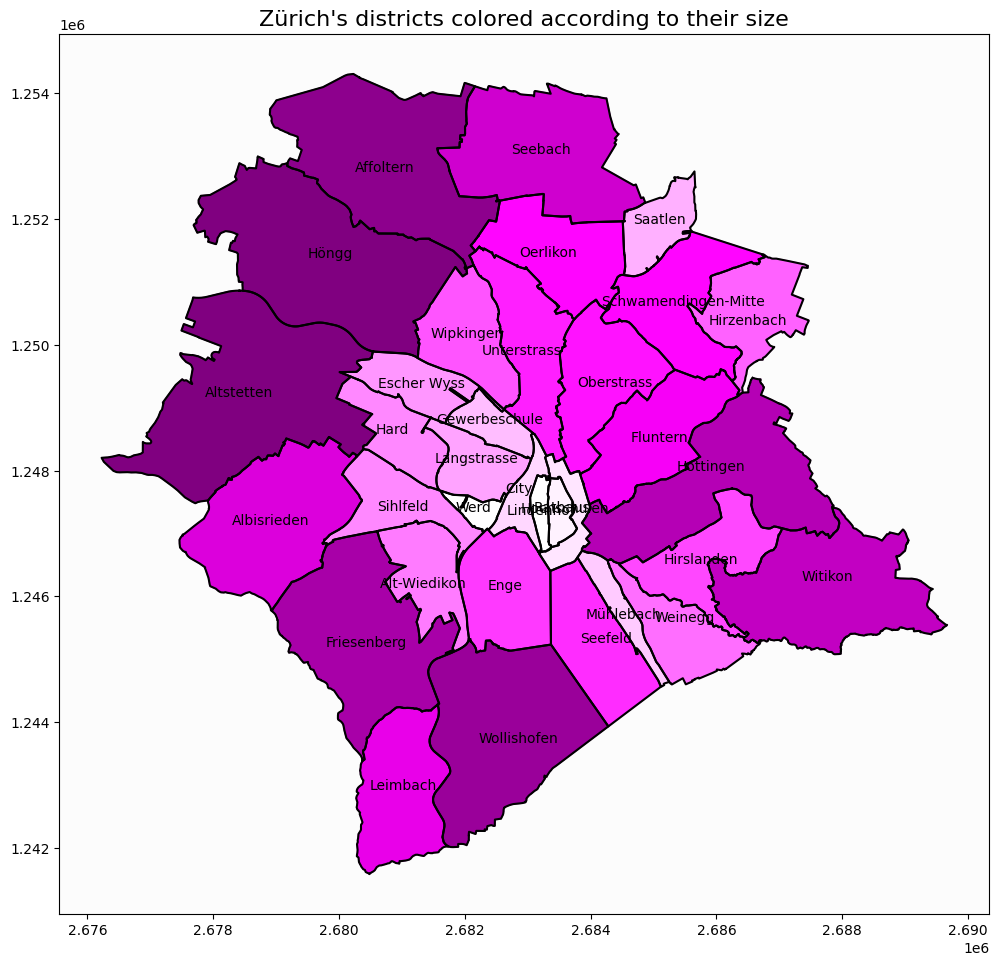

In [42]:
# plot using palette 2
data_color_tone = []
for val in data_bin_numbers:
    data_color_tone.append(color_sq[val]) 

fig, ax = plt.subplots(figsize=(12,12))
for i,district in df.iterrows():
    plot_shape(i,df,ax,mode='fill',outlinecolor='k',shownames=True,fillcolor=data_color_tone[i])

ax.set_title("Zürich's districts colored according to their size",size=16);

<a id="section-6-title"></a>
[<h3><font color=purple>6. Display districts in interactive map</font></h3>](#section-6-title)

In [48]:

transformer = Transformer.from_crs("EPSG:2056", 'epsg:4326')

list_of_shapes = df["coords"]

new_coords = []
for s in list_of_shapes:
    new_coords.append(list(zip(*transformer.transform(list(zip(*s))[0],list(zip(*s))[1]))))

df["coords_wgs84"] = new_coords

In [ ]:

testmap = folium.Map(location=[47.38,8.55], zoom_start=12) #location=[8.700720517068804, 47.5330882260687], zoom_start=13
folium.Polygon(df['coords_wgs84']).add_to(testmap) #, style_function=style_fcn #,name='geojson'
testmap

<a id="section-7-title"></a>
[<h3><font color=purple>6. Discussion</font></h3>](#section-7-title)

(1) Using Matplotlib and Pandas instead of Geopandas gives you more flexibility and control over your visualization.<br>

(2) However, it severely limits your ability to transform coordinates and to create data legends.<br>

(3) I wasn't able to plot a choropleth map without using geopandas due to the lack of a tool to convert a shpefile into a different coordinate system.<br>

(4) Thus, using only pandas for geodata is not recommendet, as it is more time consuming and code intensive to achieve the same thing. 

In [ ]:
x